###### Project: Adverse Medical Outcomes Prediction 
##### Data Scientist: Victoria M. Ng 

# Import libraries

In [82]:
# General system libraries
import os
import sys
from IPython.display import Image, Markdown
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Dataframe libraries
import pandas as pd
from pandas import DataFrame, read_csv

# Number manipulation
import scipy.sparse
from scipy.ndimage.filters import generic_filter
import patsy
import numpy as np
from scipy.stats import randint

# Plotting libaries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# Data type libaries
from datetime import datetime as dt

# File manipulation
import pickle
import pandas.io.sql as pd_sql
from sqlalchemy import create_engine
import psycopg2 as pg

# NLP libraries
import wikipedia as wiki
from nltk import word_tokenize, sent_tokenize,FreqDist
from nltk.corpus import stopwords
import gensim as gn
from gensim import corpora, models, similarities
from collections import defaultdict
from six import iteritems
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from spacy.lang.en.stop_words import STOP_WORDS

# Scraping libraries
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
chromedriver = "/home/victoria/projects/metis/Project3/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

# Stats libaries
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import datasets, linear_model, metrics
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn import svm, datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline


# Other libaries
import geopy

# Import the test and train sets

In [38]:
with open('X_train.pkl', 'rb') as picklefile: 
    X_train = pickle.load(picklefile)

In [39]:
with open('X_test.pkl', 'rb') as picklefile: 
    X_test = pickle.load(picklefile)

In [40]:
with open('y_train.pkl', 'rb') as picklefile: 
    y_train = pickle.load(picklefile)

In [41]:
with open('y_test.pkl', 'rb') as picklefile: 
    y_test = pickle.load(picklefile)

In [42]:
with open('X_train_noproduct.pkl', 'rb') as picklefile: 
    X_train_noproduct = pickle.load(picklefile)

In [43]:
with open('X_test_noproduct.pkl', 'rb') as picklefile: 
    X_test_noproduct = pickle.load(picklefile)

In [44]:
with open('y_train_noproduct.pkl', 'rb') as picklefile: 
    y_train_noproduct = pickle.load(picklefile)

In [45]:
with open('y_test_noproduct.pkl', 'rb') as picklefile: 
    y_test_noproduct = pickle.load(picklefile)

In [46]:
with open('X_noproduct.pkl', 'rb') as picklefile: 
    X_noproduct = pickle.load(picklefile)

In [47]:
with open('y_noproduct.pkl', 'rb') as picklefile: 
    y_noproduct = pickle.load(picklefile)

# Classify all features using decision tree classifier class

In [48]:
tree = DecisionTreeClassifier()

In [49]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [50]:
# It looks like the score is pretty low. Let's try without the product name feature
tree.score(X_test, y_test)

0.31940357072787917

# Classify with the test train without the product name feature

In [51]:
tree_noproduct = DecisionTreeClassifier()

In [52]:
tree_noproduct.fit(X_train_noproduct, y_train_noproduct)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Find the dummy model accuracy

In [53]:
dummy_noproduct = DummyClassifier()

In [54]:
dummy_noproduct.fit(X_train_noproduct, y_train_noproduct)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [55]:
dummy_score_noproduct = dummy_noproduct.score(X_test_noproduct, y_test_noproduct)

In [96]:
dummy_score_noproduct

0.2452422993917991

In [56]:
with open('dummy_score_noproduct.pkl', 'wb') as picklefile:
        pickle.dump(dummy_score_noproduct, picklefile)

# Run a classification report on the tree predictions

In [57]:
predictions_tree_noproduct = tree_noproduct.predict(X_test_noproduct)

In [99]:
outcomes_ordered = {'death': 0, 'life_threatening': 1, 'serious_injuries_illness': 2, 'disability': 4, 
                    'other_serious__important_medical_events_':4, 'congenital_anomaly': 5,
                   'req_intervention_to_prvnt_perm_imprmnt': 6, 'hospitalization': 7,
                   'visited_an_er': 8, 'visited_a_health_care_provider': 9}

In [58]:
# Support is the # of instances I saw of that class in the test set
# I already accounted for the unevent distribution of outcomes by using stratify in my test train split
# It seems like I have a better f1-score for:
'''
1. other_serious__important_medical_events_
2. serious_injuries_illness
3. hospitalization
BUT those classes also had the largest subset of the data
'''
print(classification_report(y_test_noproduct, predictions_tree_noproduct))

             precision    recall  f1-score   support

          0       0.16      0.19      0.17       160
          1       0.23      0.28      0.25       985
          2       0.40      0.42      0.41      2690
          3       0.23      0.22      0.22       442
          4       0.51      0.52      0.51      3791
          5       0.00      0.00      0.00         4
          6       0.16      0.14      0.15       145
          7       0.35      0.30      0.32      1486
          8       0.08      0.06      0.07       198
          9       0.17      0.12      0.14       293

avg / total       0.39      0.39      0.39     10194



/home/victoria/anaconda3/envs/ds/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Compare the accuracy of the tree with no product feature to the dummy model accuracy

In [97]:
accuracy_tree_noproduct = accuracy_score(y_test_noproduct, predictions_tree_noproduct)

In [98]:
accuracy_tree_noproduct

0.39150480674906807

In [105]:
print("My model is {}% more accurate than the dummy model".format(int((accuracy_tree_noproduct - dummy_score_noproduct)*100)))

My model is 14% more accurate than the dummy model


# Try tuning the model without the product name feature

In [95]:
decision_tree_classifier = DecisionTreeClassifier(random_state=30)

parameter_grid = {'max_depth': [5, 10, 15, 20],
                  'max_features': ['sqrt', 'log2']}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier, param_grid = parameter_grid,
                          cv = cross_validation)

grid_search.fit(X_train_noproduct, y_train_noproduct)

print("Best Score: {}".format(grid_search.best_score_))
print("Best params: {}".format(grid_search.best_params_))

Best Score: 0.38990960689510196
Best params: {'max_depth': 20, 'max_features': 'sqrt'}


# Retrain using the gridsearch chosen params

In [106]:
tree_noproduct_tuned = DecisionTreeClassifier(max_depth=20, max_features='sqrt')

In [107]:
tree_noproduct_tuned.fit(X_train_noproduct, y_train_noproduct)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Compare retrained model accuracy with dummy

In [109]:
tree_noproduct_tuned.score(X_test_noproduct, y_test_noproduct)

0.38807141455758287

Looks like the base model (the model using the default sklearn params) is more accurate than the tuned model). 

# Compare test and train scores to see whethere there's possibly overfitting

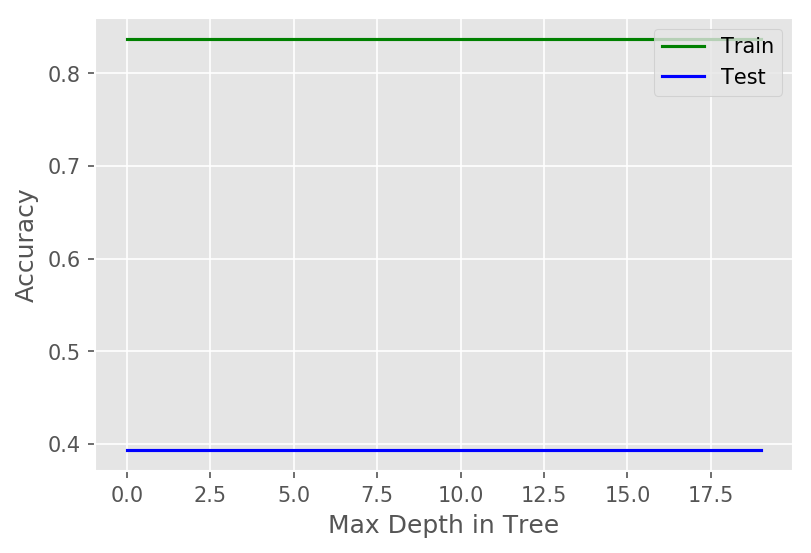

In [114]:
# Since my train score so much higher than my test score in every tree depth, I'd say I'm overfitting. 
# Therefore, I'm going to try to use bagging so that I possibly avoid this overfitting

train_score = []
test_score = []

for depth in range(20):
    tree = DecisionTreeClassifier(random_state=30)
    tree.fit(X_train_noproduct, y_train_noproduct)
    train_score.append(tree.score(X_train_noproduct, y_train_noproduct))
    test_score.append(tree.score(X_test_noproduct, y_test_noproduct))
    
plt.figure(dpi=150)
plt.plot(range(20), train_score, 'g', label="Train")
plt.plot(range(20), test_score, 'b', label="Test")
plt.legend(loc='upper right')
plt.xlabel("Max Depth in Tree")
plt.ylabel("Accuracy")
plt.savefig('Decision_Tree_TestTrainComparison', xbbox_inches='tight')


# Summary

### What I did
1. Fitted and predicted on a decision tree classification model for both of my test train sets (all features and the version without the product name codes). 
2. Conducted a grid search on the max depth and max features parameters to determine the paramaters that would provide the highest accuracy 
3. Compared the accuracy to the dummy model 
4. Compared test and train scores to see if I was overfitting. 

### What I will do next
Try using a bagging model on top of the decision tree, since I'm still overfitting.